<center><font size="10"> BigContest2019 </font> </center>

-------------------------------

<div style="text-align: right"> 홍우헌 </div>


# 데이터 수집


1. 9월에 결과물을 제출하기 전에 2019년 7~8월 데이터를 수집하여 모델에 반영할 것 
2. 지연여부를 잘 설명할 수 있는 변수들을 찾을 것
3. 기상데이터 정말 중요! - 구글드라이브에 공항별 기상원인별 지연/결항 현황 참고

     1) 안개가 기상지연 원인의 절반이상이다
     
     2) 결항의 원인은 기상원인이 최소 2배수만큼 연결지연 보다 더 크다!! 


4. 2017년 이전 데이터를 찾아 볼 것(n을 늘리자)

[공공데이터 포털 - 검색어: 한국공항공사](https://www.data.go.kr/search/index.do)


<img src="figures\figure1.PNG" width = 500> 



참고할 만한 데이터가 많다.

일일 트래픽 횟수를 추가하면 데이터를 받을 수 없으므로 주의

In [1]:
from urllib.request import urlopen, Request
import urllib
import json
import pandas as pd
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np


# Crawling the XML data  
def get_xml(name, url):
    '''
    input: name
    output: root in xml
    '''
    data = urllib.request.urlopen(url).read()
    filename = name +'.xml'
    f = open(filename, "wb")
    f.write(data)
    f.close()
    tree = ET.parse(filename)
    root = tree.getroot()
    return root

## 한국공항공사 


[한국공항공사 홈페이지](https://www.airport.co.kr/www/content/contents.do?cid=2015110913563481504&menuId=455)

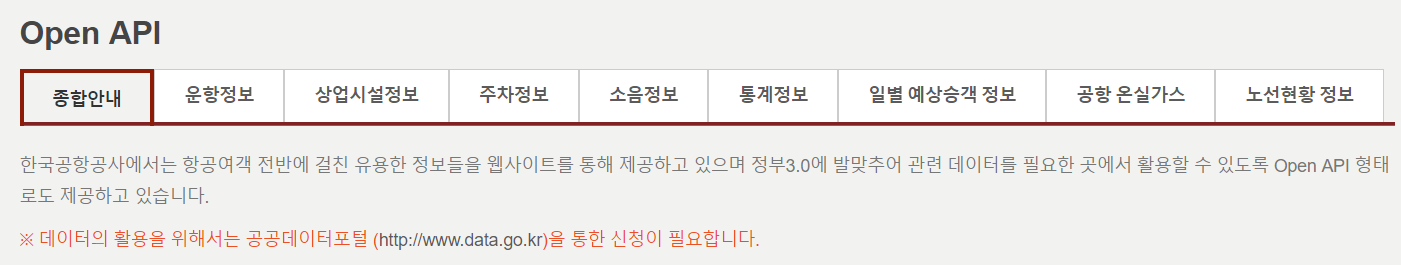

한국공항공사가 제공하는 유용한 데이터

- **항공기 운항 정보**
    - 국내선 운항 스케쥴 
- **노선 현황 정보**: 한국공항공사에서 제공하는 노선별 소요시간 및 거리 정보
- **전국공항 수송실적통계서비스**
- **일별 예상승객 정보**: <span style = 'color: red'> 김포,김해,제주 예상승객 정보 </span>

---

**NOTE**

- API로 제공하는 결항여부 파일이 없다. CSV는 있으므로 다운 받자.
- 실시간 현황 정보는 오늘 날짜에 대한 데이터만 있어서 의미가 없다.

---

크롤링 할 때에 다음 key를 사용하면 된다.

<span style = 'color: green'>serviceKey </span>= PtOpb%2FOZlzyRyICF4Cj%2Bts%2Fk6NW0fJc%2B7yn7eKuGqUVZTlo0SuAr6xn8Bb3IHUV8qRTpB1ASe%2BcdE9K3hNYrFw%3D%3D

### 국내선 운항 스케쥴 데이터 - 공항 코드화 풀기

지연 변수가 있는 데이터를 찾을 수 없었기 때문에 스케쥴 데이터로 공항을 찾는다.  

In [51]:
page_no = str(1) # 데이터 총계와 열 숫자를 알기 위한 임시 번호
url = "http://openapi.airport.co.kr/service/rest/FlightScheduleList/getDflightScheduleList?ServiceKey=PtOpb%2FOZlzyRyICF4Cj%2Bts%2Fk6NW0fJc%2B7yn7eKuGqUVZTlo0SuAr6xn8Bb3IHUV8qRTpB1ASe%2BcdE9K3hNYrFw%3D%3D&pageNo=" + page_no + "&schLineType=D"
root = get_xml("flight_status", url)
for items in root.findall('body'):
    print("열 숫자: ", items.find('numOfRows').text)
    print("페이지 번호: ", items.find('pageNo').text) 
    print("데이터 총계: ", items.find('totalCount').text)


# pre-allocation

# U는 유니코드를 의미하고 뒤의 숫자는 바이트를 의미한다. 
# FSD와 FED의 시간형태가 2018-11-25T00:00:00+09:00이기 때문에 U10으로 설정하면 
# 자동으로 날짜 뒷부분이 제거됨에 동시에 메모리 소모도 줄일 수 있다.

item_ndarray = np.empty([242600, 15], dtype = "U10")
j = 0 # row_num 


# Crwaling data and convert XML to CSV

print('process start')
for i in range(1, 24260): # 데이터 총계/ 열 숫자 만큼 페이지 번호를 반복
    page_no = str(i) 
    url = "http://openapi.airport.co.kr/service/rest/FlightScheduleList/getDflightScheduleList?ServiceKey=PtOpb%2FOZlzyRyICF4Cj%2Bts%2Fk6NW0fJc%2B7yn7eKuGqUVZTlo0SuAr6xn8Bb3IHUV8qRTpB1ASe%2BcdE9K3hNYrFw%3D%3D&pageNo=" + page_no + "&schLineType=D"
    root = get_xml("flight_status", url)
    
    for item in root.findall('body/items/item'):
        try:   
            # 제공 데이터와 동일한 순서로 열 순서를 맞춤
            item_ndarray[j, 0] = item.find('domesticNum').text
            item_ndarray[j, 1] = item.find('startcity').text
            item_ndarray[j, 2] = item.find('arrivalcity').text
            item_ndarray[j, 3] = item.find('domesticArrivalTime').text
            item_ndarray[j, 4] = item.find('domesticStartTime').text
            item_ndarray[j, 5] = item.find('airlineKorean').text 

            item_ndarray[j, 6] = item.find('domesticMon').text
            item_ndarray[j, 7] = item.find('domesticTue').text
            item_ndarray[j, 8] = item.find('domesticWed').text
            item_ndarray[j, 9] = item.find('domesticThu').text
            item_ndarray[j, 10] = item.find('domesticFri').text
            item_ndarray[j, 11] = item.find('domesticSat').text
            item_ndarray[j, 12] = item.find('domesticSun').text

            item_ndarray[j, 13] = item.find('domesticStdate').text
            item_ndarray[j, 14] = item.find('domesticEddate').text
        
        except Exception as e:
            print("This row will be ignored. ")
        
        finally:
            j += 1
    

print('process end')

df_flight_schedule = pd.DataFrame(item_ndarray, columns = ['FLT', 'ORG', 'DES', 'STA', 'STD', 'FLO', 'MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN', 'FSD', 'FED'])
df_flight_schedule.to_csv("flight_schedule2.csv", index = False, encoding='CP949') # utf-8이 안먹힘
df_flight_schedule.tail()

열 숫자:  10
페이지 번호:  1
데이터 총계:  24260
process start
process end


,FLT,ORG,DES,STA,STD,FLO,MON,TUE,WED,THU,FRI,SAT,SUN,FSD,FED
0,3P1102,무안,인천,0545,0445,에어필립,Y,Y,Y,Y,Y,Y,Y,2018-11-25,2018-11-30
1,3P1102,무안,인천,0605,0505,에어필립,N,Y,N,N,Y,N,N,2018-12-01,2018-12-31
2,3P1102,무안,인천,0555,0505,에어필립,Y,N,Y,Y,N,Y,Y,2018-12-01,2018-12-31
3,KE1493,인천,대구,0605,0515,대한항공,N,Y,N,N,N,N,N,2009-04-07,2009-04-07
4,ZE262F,인천,서울/김포,0630,0600,이스타항공,N,N,N,N,N,Y,N,2010-09-02,2010-09-17
5,7C681,무안,제주,0700,0600,제주항공,N,Y,Y,N,Y,N,Y,2018-07-22,2018-08-21
6,BX8891,서울/김포,울산,0700,0600,에어부산,N,N,N,N,Y,N,N,2019-03-31,2019-10-26
7,OZ8901,서울/김포,제주,0710,0605,아시아나항공,Y,Y,Y,Y,N,Y,Y,2014-07-25,2014-08-18
8,7C161,서울/김포,제주,0710,0605,제주항공,Y,N,N,Y,Y,Y,Y,2018-12-04,2018-12-16
9,3P1451,서울/김포,제주,0705,0605,에어필립,Y,Y,Y,Y,Y,N,N,2018-12-01,2018-12-31


In [2]:
page_no = str(1) # 데이터 총계와 열 숫자를 알기 위한 임시 번호
url = "http://openapi.airport.co.kr/service/rest/FlightScheduleList/getDflightScheduleList?ServiceKey=PtOpb%2FOZlzyRyICF4Cj%2Bts%2Fk6NW0fJc%2B7yn7eKuGqUVZTlo0SuAr6xn8Bb3IHUV8qRTpB1ASe%2BcdE9K3hNYrFw%3D%3D&pageNo=" + page_no + "&schLineType=D"
root = get_xml("flight_status", url)
for items in root.findall('body'):
    print("열 숫자: ", items.find('numOfRows').text)
    print("페이지 번호: ", items.find('pageNo').text) 
    print("데이터 총계: ", items.find('totalCount').text)


# pre-allocation

# U는 유니코드를 의미하고 뒤의 숫자는 바이트를 의미한다. 
# FSD와 FED의 시간형태가 2018-11-25T00:00:00+09:00이기 때문에 U10으로 설정하면 
# 자동으로 날짜 뒷부분이 제거됨에 동시에 메모리 소모도 줄일 수 있다.

item_ndarray = np.empty([24260, 15], dtype = "U10")
j = 0 # row_num 


# Crwaling data and convert XML to CSV

print('process start')
for i in range(1, 2426 + 1): # 데이터 총계/ 열 숫자 만큼 페이지 번호를 반복
    page_no = str(i) 
    url = "http://openapi.airport.co.kr/service/rest/FlightScheduleList/getDflightScheduleList?ServiceKey=PtOpb%2FOZlzyRyICF4Cj%2Bts%2Fk6NW0fJc%2B7yn7eKuGqUVZTlo0SuAr6xn8Bb3IHUV8qRTpB1ASe%2BcdE9K3hNYrFw%3D%3D&pageNo=" + page_no + "&schLineType=D"
    root = get_xml("flight_status", url)
    
    for item in root.findall('body/items/item'):
        try:   
            # 제공 데이터와 동일한 순서로 열 순서를 맞춤
            item_ndarray[j, 0] = item.find('domesticNum').text
            item_ndarray[j, 1] = item.find('startcity').text
            item_ndarray[j, 2] = item.find('arrivalcity').text
            item_ndarray[j, 3] = item.find('domesticArrivalTime').text
            item_ndarray[j, 4] = item.find('domesticStartTime').text
            item_ndarray[j, 5] = item.find('airlineKorean').text 

            item_ndarray[j, 6] = item.find('domesticMon').text
            item_ndarray[j, 7] = item.find('domesticTue').text
            item_ndarray[j, 8] = item.find('domesticWed').text
            item_ndarray[j, 9] = item.find('domesticThu').text
            item_ndarray[j, 10] = item.find('domesticFri').text
            item_ndarray[j, 11] = item.find('domesticSat').text
            item_ndarray[j, 12] = item.find('domesticSun').text

            item_ndarray[j, 13] = item.find('domesticStdate').text
            item_ndarray[j, 14] = item.find('domesticEddate').text
        
        except Exception as e:
            print("This row will be ignored. ")
        
        finally:
            j += 1
    

print('process end')

df_flight_schedule = pd.DataFrame(item_ndarray, columns = ['FLT', 'ORG', 'DES', 'STA', 'STD', 'FLO', 'MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN', 'FSD', 'FED'])
df_flight_schedule.to_csv("flight_schedule.csv", index = False, encoding='CP949') # utf-8이 안먹힘
df_flight_schedule

열 숫자:  10
페이지 번호:  1
데이터 총계:  24260
process start
process end


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\bigcon2019\\flight_schedule.csv'

In [4]:
df_flight_schedule.to_csv("flight_schedule.csv", index = False, encoding='CP949')

In [4]:
df_flight_schedule = pd.read_csv("flight_schedule.csv", dtype={'STA': str,'STD':str}, encoding='CP949')
df_flight_schedule

,FLT,ORG,DES,STA,STD,FLO,MON,TUE,WED,THU,FRI,SAT,SUN,FSD,FED
0,3P1102,무안,인천,0545,0445,에어필립,Y,Y,Y,Y,Y,Y,Y,2018-11-25,2018-11-30
1,3P1102,무안,인천,0605,0505,에어필립,N,Y,N,N,Y,N,N,2018-12-01,2018-12-31
2,3P1102,무안,인천,0555,0505,에어필립,Y,N,Y,Y,N,Y,Y,2018-12-01,2018-12-31
3,KE1493,인천,대구,0605,0515,대한항공,N,Y,N,N,N,N,N,2009-04-07,2009-04-07
4,ZE262F,인천,서울/김포,0630,0600,이스타항공,N,N,N,N,N,Y,N,2010-09-02,2010-09-17
5,7C681,무안,제주,0700,0600,제주항공,N,Y,Y,N,Y,N,Y,2018-07-22,2018-08-21
6,BX8891,서울/김포,울산,0700,0600,에어부산,N,N,N,N,Y,N,N,2019-03-31,2019-10-26
7,OZ8901,서울/김포,제주,0710,0605,아시아나항공,Y,Y,Y,Y,N,Y,Y,2014-07-25,2014-08-18
8,7C161,서울/김포,제주,0710,0605,제주항공,Y,N,N,Y,Y,Y,Y,2018-12-04,2018-12-16
9,3P1451,서울/김포,제주,0705,0605,에어필립,Y,Y,Y,Y,Y,N,N,2018-12-01,2018-12-31


**Convert String to DateTime**

In [5]:
from datetime import datetime as dt

# vectorized code
df_flight_schedule["STA"] = df_flight_schedule["STA"].str[0:2] + ":" + df_flight_schedule["STA"].str[2:]
df_flight_schedule["STA"] = pd.to_datetime(df_flight_schedule["STA"], format = "%H:%M").dt.time
df_flight_schedule["STD"] = df_flight_schedule["STD"].str[0:2] + ":" + df_flight_schedule["STD"].str[2:] 
df_flight_schedule["STD"] = pd.to_datetime(df_flight_schedule["STD"], format = "%H:%M").dt.time

df_flight_schedule["FSD"] = pd.to_datetime(df_flight_schedule["FSD"])
df_flight_schedule["FED"] = pd.to_datetime(df_flight_schedule["FED"])

**Test Data**

In [23]:
df_flight_schedule_test = df_flight_schedule[(df_flight_schedule['FSD'].dt.year == 2019) & (df_flight_schedule['FSD'].dt.month == 9) & (df_flight_schedule['FSD'].dt.day >= 16)]

In [50]:
df_flight_schedule[(df_flight_schedule['FSD'].dt.month == 9) & (df_flight_schedule['FSD'].dt.day < 22)]

,FLT,ORG,DES,STA,STD,FLO,MON,TUE,WED,THU,FRI,SAT,SUN,FSD,FED
4,ZE262F,인천,서울/김포,06:30:00,06:00:00,이스타항공,N,N,N,N,N,Y,N,2010-09-02,2010-09-17
33,7C161,서울/김포,제주,07:15:00,06:10:00,제주항공,N,Y,N,Y,N,Y,N,2016-09-01,2016-09-13
42,7C161,서울/김포,제주,07:15:00,06:10:00,제주항공,N,N,N,Y,N,Y,N,2016-09-15,2016-09-17
43,7C161,서울/김포,제주,07:15:00,06:10:00,제주항공,N,Y,N,Y,N,Y,N,2016-09-01,2016-09-13
52,7C161,서울/김포,제주,07:15:00,06:10:00,제주항공,N,N,N,Y,N,Y,N,2016-09-15,2016-09-17
53,7C161,서울/김포,제주,07:15:00,06:10:00,제주항공,N,Y,N,Y,N,Y,N,2016-09-01,2016-09-13
99,KE1265,서울/김포,제주,07:25:00,06:20:00,대한항공,N,N,Y,N,N,N,Y,2010-09-01,2010-10-30
109,KE1265,서울/김포,제주,07:25:00,06:20:00,대한항공,N,N,Y,N,N,N,Y,2010-09-01,2010-10-30
119,KE1265,서울/김포,제주,07:25:00,06:20:00,대한항공,N,N,Y,N,N,N,Y,2010-09-01,2010-10-30
129,KE1265,서울/김포,제주,07:25:00,06:20:00,대한항공,N,N,Y,N,N,N,Y,2010-09-01,2010-10-30


In [44]:
df_flight_schedule_test.sort_values(['FSD', 'FED', 'STA']).head()

,FLT,ORG,DES,STA,STD,FLO,MON,TUE,WED,THU,FRI,SAT,SUN,FSD,FED
8985,7C154,제주,서울/김포,13:30:00,12:20:00,제주항공,Y,Y,Y,Y,Y,Y,Y,2019-09-22,2019-09-22
8995,7C154,제주,서울/김포,13:30:00,12:20:00,제주항공,Y,Y,Y,Y,Y,Y,Y,2019-09-22,2019-09-22
9005,7C154,제주,서울/김포,13:30:00,12:20:00,제주항공,Y,Y,Y,Y,Y,Y,Y,2019-09-22,2019-09-22
9015,7C154,제주,서울/김포,13:30:00,12:20:00,제주항공,Y,Y,Y,Y,Y,Y,Y,2019-09-22,2019-09-22
9025,7C154,제주,서울/김포,13:30:00,12:20:00,제주항공,Y,Y,Y,Y,Y,Y,Y,2019-09-22,2019-09-22


In [37]:
# parse_dates는 데이터 타입을 parse datetime64[ns]로 변경
df_test = pd.read_csv("AFSNT_DLY.csv", encoding='CP949')

In [46]:
df_test.sort_values(['SDT_DD', 'STT', 'SDT_DY']).head()

,SDT_YY,SDT_MM,SDT_DD,SDT_DY,ARP,ODP,FLO,FLT,AOD,STT,DLY,DLY_RATE
39,2019,9,16,월,ARP3,ARP1,L,L1708,D,10:00,NaN,NaN
218,2019,9,16,월,ARP2,ARP1,B,B1806,D,10:00,NaN,NaN
261,2019,9,16,월,ARP1,ARP2,J,J1110,D,10:00,NaN,NaN
542,2019,9,16,월,ARP2,ARP3,J,J1005,A,10:00,NaN,NaN
646,2019,9,16,월,ARP1,ARP3,F,F1206,A,10:00,NaN,NaN


In [35]:
df_sfsnt.sort_values(['FSD', 'STD', 'STA'], ascending = FALSE)

,SSC,FLT,ORG,DES,STD,STA,FLO,MON,TUE,WED,THU,FRI,SAT,SUN,FSD,FED,IRR
409,S19,B1806,ARP2,ARP1,10:00,10:55,B,Y,Y,Y,Y,Y,Y,Y,2019-03-31,2019-10-26,N
410,S19,J1110,ARP1,ARP2,10:00,11:05,J,NaN,NaN,NaN,NaN,NaN,NaN,Y,2019-03-31,2019-10-20,N
685,S19,L1708,ARP3,ARP1,10:00,11:10,L,Y,Y,Y,Y,Y,Y,Y,2019-03-31,2019-10-26,N
759,S19,M1361,ARP10,ARP3,10:00,11:30,M,NaN,NaN,NaN,NaN,Y,NaN,NaN,2019-03-31,2019-10-26,N
629,S19,L1708,ARP3,ARP1,10:00,NaN,L,Y,Y,Y,Y,Y,Y,Y,2019-03-31,2019-10-26,N
919,S19,F1904,ARP3,ARP2,10:05,11:05,F,Y,Y,Y,Y,Y,Y,Y,2019-03-31,2019-10-26,N
1093,S19,L1805,ARP4,ARP3,10:05,11:05,L,Y,Y,NaN,Y,Y,Y,Y,2019-03-31,2019-10-26,N
1092,S19,J1955,ARP3,ARP6,10:05,11:10,J,Y,Y,Y,Y,Y,Y,Y,2019-03-31,2019-10-26,N
1094,S19,J1904,ARP8,ARP3,10:10,11:00,J,Y,Y,Y,Y,Y,Y,Y,2019-03-31,2019-10-26,N
920,S19,J1008,ARP2,ARP3,10:10,11:10,J,Y,Y,Y,Y,Y,Y,Y,2019-03-31,2019-10-26,N


### 노선현황

In [47]:
start_date = 20150701
end_date = 20190701

url = "http://openapi.airport.co.kr/service/rest/serviceLine/serviceLines?schStDate=" + str(start_date) + "&schEdDate=" + str(end_date) + "&ServiceKey=PtOpb%2FOZlzyRyICF4Cj%2Bts%2Fk6NW0fJc%2B7yn7eKuGqUVZTlo0SuAr6xn8Bb3IHUV8qRTpB1ASe%2BcdE9K3hNYrFw%3D%3D&pageNo=37"
temp = get_request_xml(url)
print(temp)

<?xml version="1.0" encoding="UTF-8" standalone="yes"?><response><header><resultCode>00</resultCode><resultMsg>NORMAL SERVICE.</resultMsg></header><body><items/><numOfRows>10</numOfRows><pageNo>37</pageNo><totalCount>355</totalCount></body></response>


## 공항탐색

### 스케쥴 데이터

In [41]:
page_no = str(1) # 데이터 총계와 열 숫자를 알기 위한 임시 번호
url = "http://openapi.airport.co.kr/service/rest/FlightScheduleList/getDflightScheduleList?ServiceKey=PtOpb%2FOZlzyRyICF4Cj%2Bts%2Fk6NW0fJc%2B7yn7eKuGqUVZTlo0SuAr6xn8Bb3IHUV8qRTpB1ASe%2BcdE9K3hNYrFw%3D%3D&pageNo=" + page_no + "&schLineType=D"
root = get_xml("flight_status", url)
for items in root.findall('body'):
    print("열 숫자: ", items.find('numOfRows').text)
    print("페이지 번호: ", items.find('pageNo').text) 
    print("데이터 총계: ", items.find('totalCount').text)
    totlaCount = items.find('totalCount').text


# pre-allocation

# U는 유니코드를 의미하고 뒤의 숫자는 바이트를 의미한다. 
# FSD와 FED의 시간형태가 2018-11-25T00:00:00+09:00이기 때문에 U10으로 설정하면 
# 자동으로 날짜 뒷부분이 제거됨에 동시에 메모리 소모도 줄일 수 있다.

item_ndarray = np.empty([totlaCount, 15], dtype = "U10")
j = 0 # row_num 


# Crwaling data and convert XML to CSV

print('process start')
for i in range(1, (totlaCount / 10) + 1): # 데이터 총계/ 열 숫자 만큼 페이지 번호를 반복
    page_no = str(i) 
    url = "http://openapi.airport.co.kr/service/rest/FlightScheduleList/getDflightScheduleList\
    ?ServiceKey=PtOpb%2FOZlzyRyICF4Cj%2Bts%2Fk6NW0fJc%2B7yn7eKuGqUVZTlo0SuAr6xn8Bb3IHUV8qRTpB1ASe%2BcdE9K3hNYrFw%3D%3D\
    &pageNo=" + page_no + "&schLineType=D"
    root = get_xml("flight_status", url)
    
    for item in root.findall('body/items/item'):
        try:   
            # 제공 데이터와 동일한 순서로 열 순서를 맞춤
            item_ndarray[j, 0] = item.find('domesticNum').text
            item_ndarray[j, 1] = item.find('startcity').text
            item_ndarray[j, 2] = item.find('arrivalcity').text
            item_ndarray[j, 3] = item.find('domesticArrivalTime').text
            item_ndarray[j, 4] = item.find('domesticStartTime').text
            item_ndarray[j, 5] = item.find('airlineKorean').text 

            item_ndarray[j, 6] = item.find('domesticMon').text
            item_ndarray[j, 7] = item.find('domesticTue').text
            item_ndarray[j, 8] = item.find('domesticWed').text
            item_ndarray[j, 9] = item.find('domesticThu').text
            item_ndarray[j, 10] = item.find('domesticFri').text
            item_ndarray[j, 11] = item.find('domesticSat').text
            item_ndarray[j, 12] = item.find('domesticSun').text

            item_ndarray[j, 13] = item.find('domesticStdate').text
            item_ndarray[j, 14] = item.find('domesticEddate').text
        
        except Exception as e:
            print("This row will be ignored. ")
        
        finally:
            j += 1
    

print('process end')

df_flight_schedule = pd.DataFrame(item_ndarray, columns = ['FLT', 'ORG', 'DES', 'STA', 'STD', 'FLO', 'MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN', 'FSD', 'FED'])
df_flight_schedule.to_csv("flight_schedule.csv", index = False, encoding='CP949') # utf-8이 안먹힘
df_flight_schedule

열 숫자:  10
페이지 번호:  1
데이터 총계:  24270


TypeError: 'str' object cannot be interpreted as an integer

In [42]:
df_flight_schedule = pd.read_csv("flight_schedule.csv", dtype = {"STD": str, "STA": str}, encoding='CP949')
df_flight_schedule["STA"] = df_flight_schedule["STA"].str[:2] + ":" + df_flight_schedule["STA"].str[2:]  
df_flight_schedule["STD"] = df_flight_schedule["STD"].str[:2] + ":" + df_flight_schedule["STD"].str[2:]  
df_flight_schedule["FSD"] = pd.to_datetime(df_flight_schedule["FSD"])
df_flight_schedule["FED"] = pd.to_datetime(df_flight_schedule["FED"])

In [76]:
df_sched = pd.read_csv("SFSNT.csv", dtype={"FSD":str, "FED":str}, encoding="CP949")
df_sched = df_sched.drop("SSC", 1)
# print(df_sched.apply(lambda x: np.sum(pd.isnull(x)))) # 결측치 존재 
df_sched.loc[:, ["STA", "STD"]] = df_sched[["STA", "STD"]].fillna("00:00")
df_sched["STA"] = pd.to_datetime(df_sched["STA"], format = "%H:%M").dt.time.astype(str) # 맨앞에 0을 만들기 위해
df_sched["STD"] = pd.to_datetime(df_sched["STD"], format = "%H:%M").dt.time.astype(str)

df_sched = df_sched.rename(columns={ 
    "ORG":"origin", "DES":"dest", 
    "FLO":"airline", "FLT":"flight",  
    "STD":"dep_time", "STA":"arr_time",  # dep: depart, arr: arrive 
    "FSD":"start_date", "FED":"end_date", 
    "IRR":"is_regular" 
})
print(df_sched["start_date"].value_counts().sort_index())
print()
print(df_sched["end_date"].value_counts().sort_index())

20190331    569
20190401     45
20190402     14
20190403      6
20190404      8
20190405      9
20190406      4
20190407      4
20190411      2
20190415      6
20190416      4
20190417      1
20190418      2
20190419      3
20190425      1
20190427      1
20190428     15
20190429     15
20190430      6
20190501      2
20190503      5
20190504      5
20190505      2
20190507      2
20190509      1
20190511      2
20190513      2
20190514      2
20190515      2
20190517      2
           ... 
20190804      6
20190805     35
20190806      4
20190807      2
20190808      5
20190809     14
20190810      4
20190812      2
20190813      1
20190826      3
20190827      2
20190828      1
20190830      1
20190831      2
20190901      6
20190902     20
20190903      7
20190904      2
20190905      7
20190906      1
20190907      2
20190909      3
20190910      2
20190911      1
20190914      2
20190916      2
20190917      2
20190922      6
20190923      2
20190924      6
Name: start_date, Length

스케쥴데이터의 FSD는 3-31부터 9-24, FED는 7-03부터 10-27이다.

In [60]:
df_flight_schedule[(df_flight_schedule["FSD"].dt.year == 2019)]

,FLT,ORG,DES,STA,STD,FLO,MON,TUE,WED,THU,FRI,SAT,SUN,FSD,FED
6,BX8891,서울/김포,울산,07:00,06:00,에어부산,N,N,N,N,Y,N,N,2019-03-31,2019-10-26
11,3P1451,서울/김포,제주,07:00,06:05,에어필립,Y,N,Y,N,Y,Y,Y,2019-02-01,2019-02-08
13,3P1451,서울/김포,제주,07:00,06:05,에어필립,Y,N,Y,N,Y,Y,Y,2019-01-01,2019-01-31
21,3P1451,서울/김포,제주,07:00,06:05,에어필립,Y,N,Y,N,Y,Y,Y,2019-02-01,2019-02-08
23,3P1451,서울/김포,제주,07:00,06:05,에어필립,Y,N,Y,N,Y,Y,Y,2019-01-01,2019-01-31


19년 데이터가 몇개 없다.

In [68]:
df_flight_schedule["FSD"].dt.year.value_counts()

2009    9624
2008    8604
2017    3150
2010    1991
2018     268
2013     198
2014     182
2011     156
2012      38
2016      32
2015      12
2019       5
Name: FSD, dtype: int64

년도가 지남에 따라 개수가 확연히 줄고 있다.

In [71]:
df_flight_schedule[df_flight_schedule["FSD"].dt.year == 2009]

,FLT,ORG,DES,STA,STD,FLO,MON,TUE,WED,THU,FRI,SAT,SUN,FSD,FED
3,KE1493,인천,대구,06:05,05:15,대한항공,N,Y,N,N,N,N,N,2009-04-07,2009-04-07
159,KE1207,서울/김포,제주,07:30,06:25,대한항공,Y,Y,Y,Y,Y,Y,Y,2009-05-07,2009-10-24
169,ZE251,서울/김포,제주,07:30,06:25,이스타항공,Y,Y,Y,Y,Y,Y,Y,2009-08-01,2009-08-10
179,ZE251,서울/김포,제주,07:30,06:25,이스타항공,Y,Y,Y,Y,Y,Y,Y,2009-08-01,2009-08-10
189,ZE251,서울/김포,제주,07:30,06:25,이스타항공,Y,Y,Y,Y,Y,Y,Y,2009-08-01,2009-08-10
199,ZE251,서울/김포,제주,07:30,06:25,이스타항공,Y,Y,Y,Y,Y,Y,Y,2009-08-01,2009-08-10
209,ZE251,서울/김포,제주,07:30,06:25,이스타항공,Y,Y,Y,Y,Y,Y,Y,2009-08-01,2009-08-10
215,ZE251,서울/김포,제주,07:30,06:25,이스타항공,Y,Y,Y,Y,Y,Y,Y,2009-08-01,2009-08-10
216,KE1002,제주,부산/김해,07:25,06:30,대한항공,Y,N,N,N,N,Y,0,2009-03-29,2009-10-24
217,7C101,서울/김포,제주,07:50,06:30,제주항공,Y,Y,Y,Y,Y,Y,Y,2009-05-04,2009-10-05


최근 자료가 없다고 결론을 내림

방법을 바꿔서 노선 소요시간을 비교하였다.

### 노선별 소요시간 및 거리 정보

In [103]:
# pre-allocation
item_ndarray = np.empty([46, 4], dtype = "U10")
j = 0 # row_num 

# Crwaling data and convert XML to CSV

print('process start')
url = "http://openapi.airport.co.kr/service/rest/serviceLine/serviceLines?schStDate=20170101&schEdDate=20190630&schLineType=D&pageNo=1&numOfRows=100&ServiceKey=PtOpb%2FOZlzyRyICF4Cj%2Bts%2Fk6NW0fJc%2B7yn7eKuGqUVZTlo0SuAr6xn8Bb3IHUV8qRTpB1ASe%2BcdE9K3hNYrFw%3D%3D"
root = get_xml("flight_status", url)

for item in root.findall('body/items/item'):
    try:   
        # 제공 데이터와 동일한 순서로 열 순서를 맞춤
        item_ndarray[j, 0] = item.find('arp').text
        item_ndarray[j, 1] = item.find('odp').text
        item_ndarray[j, 2] = item.find('km').text
        item_ndarray[j, 3] = item.find('time').text

    except Exception as e:
        print("This row will be ignored. ")

    finally:
        j += 1
    

print('process end')

df_flight_airtime = pd.DataFrame(item_ndarray, columns = ['ARP', 'ODP', 'KM', 'TIME'])
df_flight_airtime.to_csv("flight_time_distance.csv", index = False, encoding='CP949') # utf-8이 안먹힘
df_flight_airtime

process start
process end


,ARP,ODP,KM,TIME
0,CJJ,CJU,367,42
1,CJU,YNY,542,55
2,CJU,WJU,456,49
3,CJU,GMP,449,48
4,CJU,KPO,383,43
5,CJU,CJJ,367,42
6,CJU,USN,349,41
7,CJU,TAE,330,39
8,CJU,PUS,291,36
9,CJU,KUV,266,34


### 공항코드

In [104]:
# pre-allocation
item_ndarray = np.empty([980, 3], dtype = "U10")
j = 0 # row_num 

# Crwaling data and convert XML to CSV

print('process start')
url = "http://openapi.airport.co.kr/service/rest/AirportCodeList/getAirportCodeList?schStDate=20170101&schEdDate=20190630&schLineType=D&pageNo=1&numOfRows=980&ServiceKey=PtOpb%2FOZlzyRyICF4Cj%2Bts%2Fk6NW0fJc%2B7yn7eKuGqUVZTlo0SuAr6xn8Bb3IHUV8qRTpB1ASe%2BcdE9K3hNYrFw%3D%3D"
root = get_xml("flight_status", url)

for item in root.findall('body/items/item'):
    try:   
        # 제공 데이터와 동일한 순서로 열 순서를 맞춤
        item_ndarray[j, 0] = item.find('cityCode').text
        item_ndarray[j, 1] = item.find('cityEng').text
        item_ndarray[j, 2] = item.find('cityKor').text

    except Exception as e:
        print("This row will be ignored. ")

    finally:
        j += 1
    

print('process end')

df_airport_code = pd.DataFrame(item_ndarray, columns = ['cityCode', 'cityEng', 'cityKor'])
df_airport_code.to_csv("flight_time_distance.csv", index = False, encoding='CP949') # utf-8이 안먹힘
df_airport_code

process start
process end


,cityCode,cityEng,cityKor
0,KWI,KUWAIT,쿠웨이트
1,KWJ,Gwangju,광주
2,KWL,GUILIN,계림
3,KXK,KOMSOMSKNA,콤솜스크나무르
4,KZA,KAZAKHSTAN,카자흐스탄
5,KZK,KOMPONGTHO,콤퐁
6,KZN,KAZAN,카잔
7,LAD,LUANDA,르완다
8,LAH,LABUHA,라부하
9,LAO,LAOAG,라오아그


공항코드도 크롤링한다.

In [105]:
df_flight_airtime = pd.merge(df_flight_airtime, df_airport_code, how = "left", left_on = "ARP", right_on = "cityCode")
df_flight_airtime.drop_duplicates("ARP")

,ARP,ODP,KM,TIME,cityCode,cityEng,cityKor
0,CJJ,CJU,367,42,CJJ,Cheongju,청주
1,CJU,YNY,542,55,CJU,Jeju,제주
14,GMP,CJU,449,48,GMP,Gimpo,서울/김포
22,HIN,GMP,298,37,HIN,Sacheon,사천
24,ICN,CJU,438,47,ICN,Incheon,인천
26,KPO,CJU,383,43,KPO,Pohang,포항
28,KUV,CJU,266,34,KUV,Gunsan,군산
29,KWJ,GMP,270,35,KWJ,Gwangju,광주
31,MWX,CJU,164,27,MWX,Muan,무안
32,PUS,GMP,327,39,PUS,Gimhae,부산/김해


In [124]:
df_sched["airtime"] = df_sched["arr_time"].str[:2].astype(int) * 60 + df_sched["arr_time"].str[3:5].astype(int) - \
                    (df_sched["dep_time"].str[:2].astype(int) * 60 + df_sched["dep_time"].str[3:5].astype(int))
df_flight_airtime["TIME"].value_counts().sort_index()

      27
27     2
28     4
32     2
33     2
34     4
35     2
36     4
37     2
38     4
39     4
41     2
42     2
43     2
47     1
48     2
49     2
55     2
Name: TIME, dtype: int64

In [126]:
df_sched["airtime"].value_counts().sort_index()

-1265      1
-1230      1
-1195      1
-1165      1
-1025      1
-980       1
-950       1
-905       1
-810       1
-765       1
-735       1
-700       1
-695       1
-665       1
-600       1
-525       1
-505       1
-475       1
 0         1
 40        1
 45        3
 50       43
 55      101
 60      301
 65      186
 69        1
 70      452
 75       44
 80        9
 85        2
 90        4
 95        3
 545       1
 575       1
 595       1
 670       1
 735       1
 765       1
 770       1
 805       1
 835       1
 880       1
 975       1
 1020      1
 1050      1
 1095      1
 1235      1
 1265      1
 1300      1
Name: airtime, dtype: int64

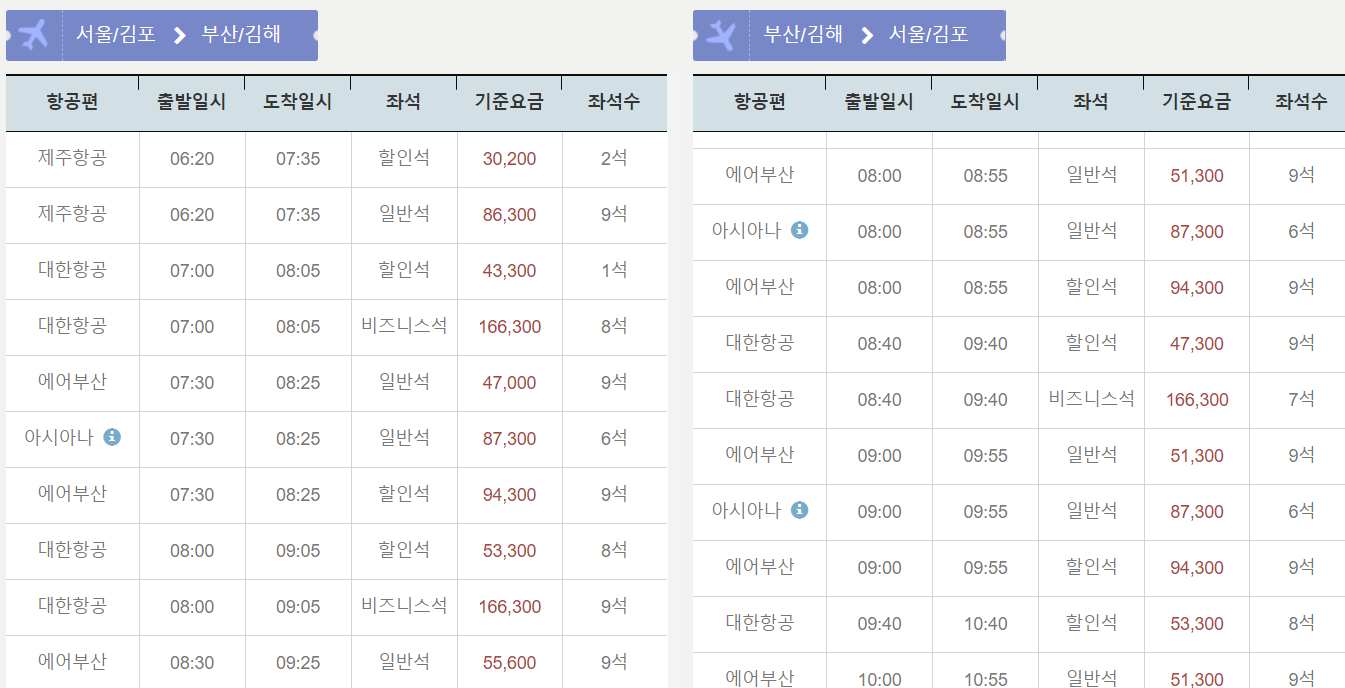

비행기마다 비행시간이 너무 달라서 이 방법을 사용할 수는 없다는 것을 알게되었다.

### 월별 통계

In [2]:
import pandas as pd

df_afsnt = pd.read_csv("AFSNT.csv", encoding="CP949")
df_afsnt["STT"] = pd.to_datetime(df_afsnt["STT"], format = "%H:%M").dt.time
df_afsnt["ATT"] = pd.to_datetime(df_afsnt["ATT"], format = "%H:%M").dt.time

df_afsnt = df_afsnt.rename(columns={ 
    "SDT_YY": "year", "SDT_MM":"month", "SDT_DD":"day",  "SDT_DY":"wday", 
    "ARP":"origin", "ODP":"dest", 
    "FLO":"airline", "FLT":"flight" ,"REG":"tailnum", 
    "AOD":"is_arrive", 
    "IRR":"is_regular", 
    "STT":"sched_time", "ATT":"real_time", 
    "DLY":"is_delay", "DRR":"cause_delay", 
    "CNL":"is_cancel", "CNR":"cause_cancel"
})


항공공항공사 통계를 엑셀파일로 다운받으면 xls인데 데이터 형태가 특이해서 read_excel로 읽혀지지 않는다. 따라서 read_html로 읽고나서 데이터프레임으로 변환

In [3]:
import os
import numpy as np

year = [17, 18, 19]
month = list(range(1, 13))
year_month = np.array(np.meshgrid(month, year)).reshape(2, -1).T
df_year_month = pd.DataFrame(year_month, columns = ['month', 'year'])
df_delay_stat = []

for i in range(len(os.listdir("공항별지연통계"))):
    df = pd.read_html("공항별지연통계\\" + os.listdir("공항별지연통계")[i], encoding = "utf8")[0][:13] 
    df['year'] = df_year_month['year'][i]
    df['month'] = df_year_month['month'][i]
    df_delay_stat.append(df)
    
df_delay_stat = pd.concat(df_delay_stat)
df_delay_stat.to_csv('df_delay_stat.csv', index=False)
df_delay_stat

,공항명,운항(횟수),기상,A/C접속,A/C정비,여객처리,복합원인,기타,계,year,month
0,김포,10317,3,1188,19,7,0,123,1340,17,1
1,김해,4045,2,435,6,1,0,44,488,17,1
2,제주,12573,13,1841,16,2,0,33,1905,17,1
3,대구,1058,0,106,2,0,0,1,109,17,1
4,광주,935,2,96,2,0,0,2,102,17,1
5,무안,62,0,0,0,0,0,4,4,17,1
6,청주,1042,7,122,2,1,0,13,145,17,1
7,여수,412,0,40,0,0,0,0,40,17,1
8,울산,432,1,33,0,0,0,3,37,17,1
9,사천,158,0,19,0,0,0,0,19,17,1


In [ ]:
np.where

In [40]:
df_airport_stat = []

for i in range(len(os.listdir("공항별통계"))):
    df = pd.read_html("공항별통계\\" + os.listdir("공항별통계")[i], encoding = "utf8")[0][:13] 
    df['year'] = df_year_month['year'][i]
    df['month'] = df_year_month['month'][i]
    df_airport_stat.append(df)
    
df_airport_stat = pd.concat(df_airport_stat)
df_airport_stat.to_csv('df_airport_stat.csv', index=False)
df_airport_stat

공항명 운항(편수)                 여객(명)                    화물(ton)           \
   공항명     도착    출발      계       도착       출발        계       도착       출발   
0   김포   5199  5202  10401   839534   817492  1657026  10787.2   6846.5   
1   김해   2042  2044   4086   312143   309062   621205   3138.3   2359.0   
2   제주   6327  6329  12656  1064050  1099395  2163445   9190.2  14598.7   
3   대구    541   542   1083    83717    80719   164436    853.5    613.8   
4   광주    473   471    944    71128    68386   139514    699.7    631.3   
5   무안     31    31     62     5365     4811    10176     28.7     19.3   
6   청주    521   521   1042    86395    83432   169827    881.6    557.0   
7   여수    206   206    412    24295    24983    49278    112.1    121.2   
8   울산    216   216    432    24271    24163    48434    126.9    108.4   
9   사천     79    79    158     7315     7067    14382     32.5     28.9   
10  포항     60    60    120     4840     5191    10031     14.4     16.9   
11  군산     53    53    106     8994     8814    17808     60.3     50.2   
12  원주     28    28     56     3178     3119     6297     21.1     15.9   
0   김포   4586  4596   9182   744938   735942  1480880   9129.4   6232.4   
1   김해   1860  1857   3717   280373   284767   565140   2676.4   2077.2   
2   제주   5714  5719  11433   995065   992210  1987275   8476.0  12458.5   
3   대구    498   497    995    73122    75736   148858    796.2    575.6   
4   광주    416   416    832    60795    62230   123025    528.0    539.1   
5   무안     28    28     56     4781     4635     9416     21.8     16.7   
6   청주    564   564   1128    90703    92463   183166    884.6    604.3   
7   여수    192   192    384    21252    22751    44003     89.4    102.5   
8   울산    193   192    385    18732    19411    38143     91.9     83.1   
9   사천     71    70    141     6159     6221    12380     25.0     23.5   
10  포항     54    54    108     3577     3890     7467     10.5     11.1   
11  군산     54    54    108     8601     9175    17776     47.2     46.0   
12  원주     26    26     52     2944     3139     6083     17.9     15.6   
0   김포   5263  5261  10524   790610   799336  1589946   9590.7   6499.9   
1   김해   2042  2044   4086   292566   296124   588690   2728.3   2259.0   
2   제주   6542  6545  13087  1070154  1049445  2119599   8849.0  12916.2   
3   대구    556   556   1112    79050    80231   159281    806.5    652.4   
..  ..    ...   ...    ...      ...      ...      ...      ...      ...   
9   사천     80    80    160     9436     8850    18286     37.9     29.3   
10  포항     58    58    116     3752     4104     7856     15.9     15.0   
11  군산     90    90    180    14180    14198    28378     78.8     67.5   
12  원주     46    47     93     5505     5902    11407     34.9     29.0   
0   김포   5288  5290  10578   938154   917370  1855524   6076.1   6846.5   
1   김해   2002  2003   4005   313774   318052   631826   2209.0   2456.7   
2   제주   6829  6832  13661  1238979  1254896  2493875   9533.9   8485.5   
3   대구    577   572   1149    89912    91645   181557    637.2    646.8   
4   광주    560   559   1119    89623    89670   179293    541.6    629.3   
5   무안     62    62    124    10005     9091    19096     45.2     35.1   
6   청주    633   633   1266   109042   108556   217598    587.0    605.5   
7   여수    214   213    427    27349    28699    56048    122.4    116.8   
8   울산    272   272    544    32537    33032    65569    179.2    140.3   
9   사천     83    83    166     9992     9765    19757     41.1     34.8   
10  포항     60    60    120     4204     4582     8786     17.6     14.5   
11  군산     89    89    178    14009    13755    27764     77.5     65.4   
12  원주     31    32     63     3683     3790     7473     22.6     17.7   
0   김포   5165  5172  10337   910505   898370  1808875   5984.3   6562.1   
1   김해   1960  1959   3919   314478   315193   629671   2098.2   2381.1   
2   제주   6682  6685  13367  1221841  1232757  2454598   9209.8   8150.9   
3   대구    551   551   1102  

In [1]:
library(tidyverse)
library(lubridate)
library(gridExtra)


df_afsnt <- 
    data.table::fread("df_afsnt.csv") %>% 
    as_tibble() %>% 
    select(year, month, origin, dest, is_delay, is_cancel)

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
√ ggplot2 3.2.0     √ purrr   0.3.2
√ tibble  2.1.3     √ dplyr   0.8.3
√ tidyr   0.8.3     √ stringr 1.4.0
√ readr   1.3.1     √ forcats 0.4.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



In [ ]:
df_airport_stat <- 
    read_csv("df_delay_stat.csv")

In [ ]:
df_afsnt_stat <- df_afsnt %>% 
    group_by(year, month) %>% 
    summarise(sum_delay = sum(is_delay),
             sum_cancel = sum(is_cancel)) 

ggplot(df_afsnt_stat, aes(month, sum_delay, color = fct_reorder2(origin, month, sum_delay), group = fct_reorder2(origin, month, sum_delay))) + 
    geom_line() +
facet_wrap(~year, ncol = 1)

공항수 찾기를 다음과 같이 진행하였습니다.
빅콘데이터 월별 공항별 지연수/결항수 플랏과 공항공사 데이터 플랏을 비교하였습니다.

1. 전체 값을 가지고 공항을 1차적으로 찾는다.
2. 월별 값을 비교하면서 계속 수정해나간다.
3. 더이상 수정이 안되면 종료



지연수 내림차순입니다.


전체 기준 
- ARP3: 제주
- ARP1: 김포
- ARP2: 김해 
- ARP6: 청주, 대구, 광주
- ARP4: 광주, 대구, 청주 
- ARP8: 대구, 광주, 청주 
- ARP15: 울산 
- ARP9: 인천, 여수
- ARP13: 여수, 인천 
- ARP7: 사천, 군산, 포항, 무안 
- ARP5: 군산, 사천, 포항, 무안
- ARP12: 포항, 무안, 군산, 사천
- APR11: 무안, 포항, 군산, 사천 
- ARP14: 양양
- ARP10:

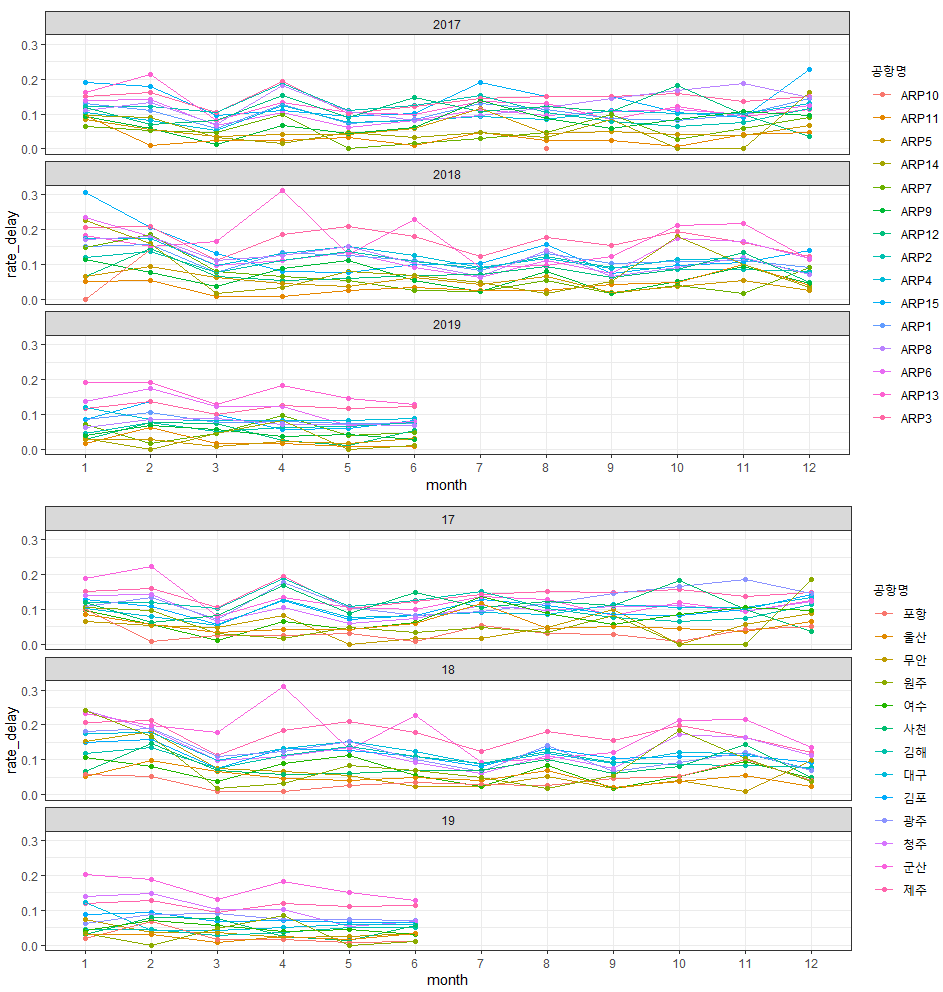

결항수 내림차순입니다.

- ARP3:  제주
- ARP1: 김포 
- ARP2: 김해
- ARP13: 
- ARP14:
- ARP12:
- ARP15:
- ARP11:
- ARP5:
- ARP7:
- ARP8:
- ARP10:
- ARP4:
- ARP6:
- ARP9:


# EDA

경험상 EDA로 변수를 만드는 것이 예측 정확도를 높이기에는 투자 시간 대비 효용이 극악이다. 그래서 대안으로 model based 시각화 방법을 제안한다.

[Network model trees](https://www.r-bloggers.com/network-model-trees/)

지연여부를 outcome으로 하는 tree 모형에서 네트워크를 생성하여 이 subgroup들에서의 네트워크의 중심성 척도들을 변수로 만든다.

In [1]:
import sklearn.datasets as d
import sklearn.model_selection as ms
import sklearn.metrics as mt
import sklearn
import sklearn.linear_model as lm
from datetime import datetime


df_afsnt = pd.read_csv("AFSNT.csv", encoding="CP949")
df_afsnt["STT"] = pd.to_datetime(df_afsnt["STT"], format = "%H:%M").dt.time
df_afsnt["ATT"] = pd.to_datetime(df_afsnt["ATT"], format = "%H:%M").dt.time

df_afsnt = df_afsnt.rename(columns={'SDT_YY': 'YEAR', 'SDT_MM':'MONTH', 'SDT_DD':'DAY'})
df_afsnt["date"] = pd.to_datetime(df_afsnt[["YEAR", "MONTH", "DAY"]])
df_afsnt["datetime_schedule"] = pd.to_datetime(df_afsnt['date'].astype(str) + " " + df_afsnt["STT"].astype(str))
df_afsnt["datetime_real"] = pd.to_datetime(df_afsnt['date'].astype(str) + " " + df_afsnt["ATT"].astype(str))

# diff 변수 생성
temp = df_afsnt["datetime_schedule"] - df_afsnt["datetime_real"] # delay변수는 계획시각에서 실제시각의 차이
temp = pd.DataFrame(temp.dt.components)
df_afsnt["diff"] = temp['minutes'] + 60 * temp['hours'] + 1440 * temp['days']
del temp

df_afsnt.to_csv("df_afsnt.csv", index = False, encoding='CP949')

NameError: name 'pd' is not defined

시간 관계상 R로 작업하였다.

In [3]:
library(tidyverse)
library(lubridate)
library(gridExtra)

df_test <- data.table::fread("AFSNT_DLY.csv") %>% as_tibble()
df_afsnt <- 
  data.table::fread("AFSNT.csv") %>% 
  as_tibble() %>% 
  rename(
    year = SDT_YY, 
    month = SDT_MM, 
    day = SDT_DD,
    wday = SDT_DY,
    origin = ARP,
    dest = ODP,
    airline = FLO,
    flight = FLT,
    tailnum = REG,
    is_regular = IRR,
    sched_time = STT,
    real_time =  ATT,
    is_delay = DLY,
    is_arrive = AOD,
    cause_delay = DRR,
    is_cancel = CNL,
    cause_cancel = CNR
    ) %>% 
  mutate(sched_hour = as.integer(str_extract(sched_time, "\\d{1,2}")),
         sched_minute = as.integer(str_extract(sched_time, "\\d{2}$")),
         real_hour = as.integer(str_extract(real_time, "\\d{1,2}")),
         real_minute = as.integer(str_extract(real_time, "\\d{2}$"))) %>% 
  mutate(
    sched_datetime = make_datetime(year, month, day, sched_hour, sched_minute),
    real_datetime = make_datetime(year, month, day, real_hour, real_minute),
    diff = -as.duration(real_datetime %--% sched_datetime) / dminutes(1)
    )
df_sfsnt <- data.table::fread("SFSNT.csv") %>% as_tibble()

theme_set(theme_bw())
options(repr.plot.width=10, repr.plot.height=8)


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



### Univariate 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


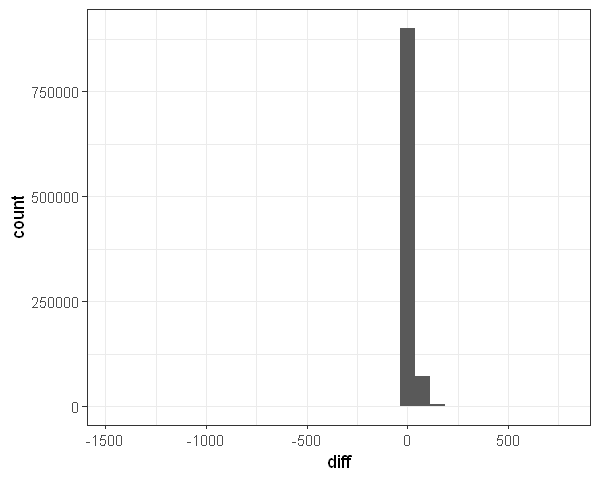

In [12]:
ggplot(df_afsnt, aes(diff)) +
  geom_histogram()

-500보다 작은 것들에 대해 

In [15]:
df_afsnt %>% 
  filter(diff < -500) %>% 
  select(sched_datetime, real_datetime, diff, is_delay, is_cancel) %>% 
  car::some()


sched_datetime,real_datetime,diff,is_delay,is_cancel
<dttm>,<dttm>,<dbl>,<chr>,<chr>
2017-09-28 09:30:00,2017-09-28,-570,N,Y
2017-11-26 10:00:00,2017-11-26,-600,N,Y
2017-07-04 16:05:00,2017-07-04,-965,N,Y
2017-04-05 19:50:00,2017-04-05,-1190,N,Y
2018-01-11 17:45:00,2018-01-11,-1065,N,Y
2018-10-05 16:35:00,2018-10-05,-995,N,Y
2018-12-17 08:30:00,2018-12-17,-510,N,Y
2018-05-06 11:20:00,2018-05-06,-680,N,Y
2018-08-23 17:10:00,2018-08-23,-1030,N,Y


In [ ]:
도착시간이 0분인 것들은 결항이였다.

결항을 제거하고 다시 시각화진행

In [16]:
df_afsnt2 <- filter(df_afsnt, is_cancel == "N")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 852517 rows containing non-finite values (stat_bin)."Warning message:
"Removed 1 rows containing missing values (geom_bar)."

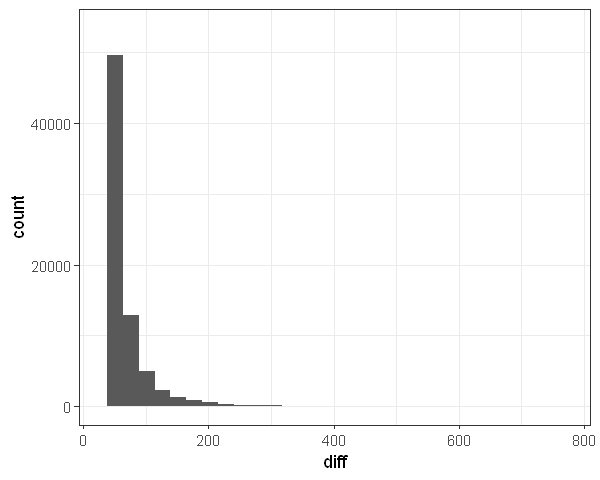

In [17]:
ggplot(df_afsnt2, aes(diff)) +
  geom_histogram() +
  xlim(30, NA)

지연시간은 오른쪼 꼬리가 긴 power function. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 736333 rows containing non-finite values (stat_bin)."Warning message:
"Removed 2 rows containing missing values (geom_bar)."

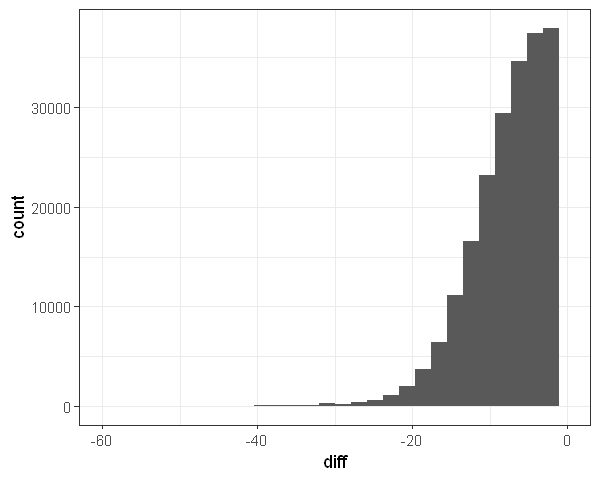

In [18]:
ggplot(df_afsnt2, aes(diff)) +
  geom_histogram() +
  xlim(-60, 0)

50분보다 더 빨리 도착하는 경우는 거의 없다.


In [19]:
df_afsnt2 %>% 
  filter(diff < -60) %>% 
  select(sched_datetime, real_datetime, diff, is_delay, is_cancel) %>% 
  car::some()

sched_datetime,real_datetime,diff,is_delay,is_cancel
<dttm>,<dttm>,<dbl>,<chr>,<chr>
2017-12-08 18:45:00,2017-12-08 17:39:00,-66,N,N
2018-11-23 17:45:00,2018-11-23 08:07:00,-578,N,N
2018-08-14 17:00:00,2018-08-14 14:20:00,-160,N,N
2018-02-01 17:15:00,2018-02-01 15:24:00,-111,N,N
2018-09-19 22:15:00,2018-09-19 10:36:00,-699,N,N
2018-12-29 19:05:00,2018-12-29 09:48:00,-557,N,N
2018-01-11 22:25:00,2018-01-11 02:03:00,-1222,N,N
2018-01-06 19:00:00,2018-01-06 06:59:00,-721,N,N
2019-02-19 16:50:00,2019-02-19 15:48:00,-62,N,N


In [ ]:
굉장히 일찍 출발하는 비행기들이 있다.

In [20]:
df_afsnt %>% 
  arrange(desc(diff)) %>% 
  select(diff, sched_time, real_time, year, month, day, origin, dest, airline, flight) %>% 
  car::some()

diff,sched_time,real_time,year,month,day,origin,dest,airline,flight
<dbl>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
47,16:10,16:57,2018,12,13,ARP1,ARP3,F,F1216
36,16:05,16:41,2017,10,27,ARP4,ARP3,H,H1705
20,9:10,9:30,2017,10,20,ARP1,ARP2,B,B1833
16,7:10,7:26,2018,3,25,ARP1,ARP3,A,A1911
15,17:00,17:15,2017,7,23,ARP2,ARP1,B,B1820
15,17:40,17:55,2017,7,18,ARP3,ARP4,A,A1128
15,6:20,6:35,2017,4,20,ARP4,ARP3,L,L1815
15,12:15,12:30,2018,2,3,ARP2,ARP3,H,H1509
-9,12:20,12:11,2018,8,6,ARP1,ARP3,J,J1217


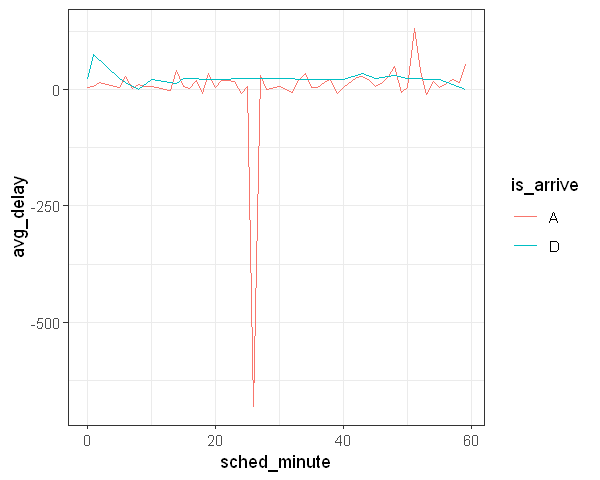

In [21]:
## 분 단위
df_afsnt2 %>% 
  group_by(sched_minute, is_arrive) %>% 
  summarise(
    avg_delay = mean(diff)
  ) %>% 
  ggplot(aes(sched_minute, avg_delay, color = is_arrive)) +
  geom_line()

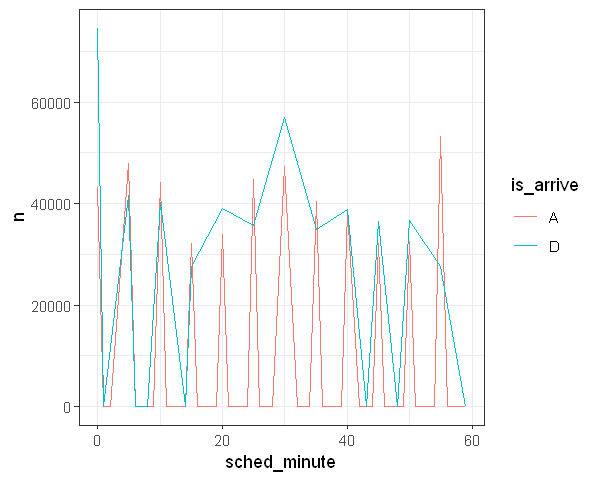

In [22]:
df_afsnt2 %>% 
  group_by(sched_minute, is_arrive) %>% 
  summarise(
    n = n()
  ) %>% 
  ggplot(aes(sched_minute, n, color = is_arrive)) +
  geom_line()

도착은 5분단위로 예정시각이 
출발은???

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


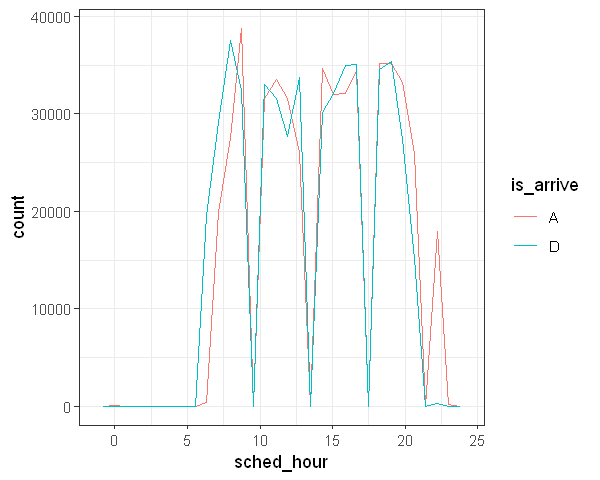

In [23]:
df_afsnt2 %>%
  ggplot(aes(sched_hour, color = is_arrive)) +
  geom_freqpoly()

식사 시간에 비행기가 덜 뜨고 늦은 밤엔 비행기가 도착만 하지 뜨지는 않는다. 약 6시 이후로 비행기가 뜸.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


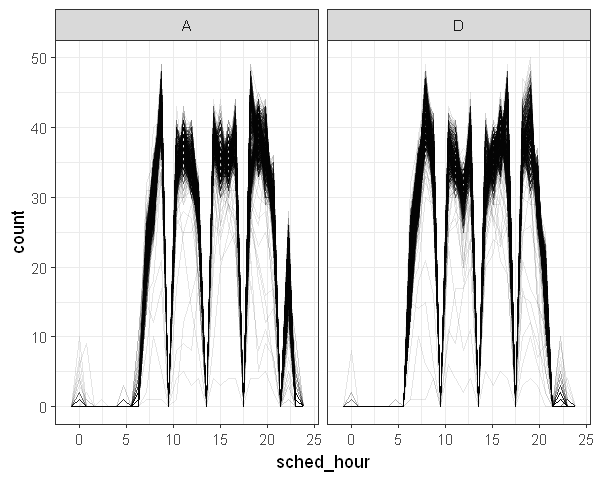

In [24]:
df_afsnt2 %>%
  mutate(date = make_date(year,
                          month,
                          day)) %>% 
  group_by(date, sched_hour) %>%
  ggplot(mapping = aes(x = sched_hour, group = date)) +
  geom_freqpoly(alpha = .1) +
  facet_wrap(~is_arrive)

연중 분포를 보기 위해 그렸다.

In [25]:
summary(df_afsnt2$sched_hour)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   10.00   14.00   13.95   18.00   23.00 

In [ ]:
설명회에서 설명하신 누님도 말씀하셨지만 11시 이후로는 비행기가 뜨지 않는다.

In [27]:
df_afsnt2 %>% 
  filter(sched_hour > 1 & sched_hour < 6) %>% 
  select(diff, sched_time, real_time, year, month, day, origin, dest, airline, flight) %>% 
  car::some()

diff,sched_time,real_time,year,month,day,origin,dest,airline,flight
<dbl>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
14,5:15,5:29,2018,2,26,ARP10,ARP15,J,J1802
35,5:47,6:22,2018,9,14,ARP1,ARP15,F,F1262F
30,5:55,6:25,2018,8,25,ARP1,ARP15,A,A1807A
19,5:55,6:14,2018,9,14,ARP1,ARP15,A,A1805A
101,5:50,7:31,2018,8,20,ARP1,ARP15,H,H1932F
70,5:50,7:00,2018,8,22,ARP1,ARP15,H,H1932F
83,5:50,7:13,2018,8,25,ARP1,ARP15,H,H1932F
55,5:50,6:45,2018,8,26,ARP1,ARP15,H,H1932F
16,5:57,6:13,2018,8,25,ARP1,ARP15,I,I1931F


1시 이후 6시 이전에 뜨는 비행기는 총 25편
이유는 알수없음.

하루 동안의 평균 delay time

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


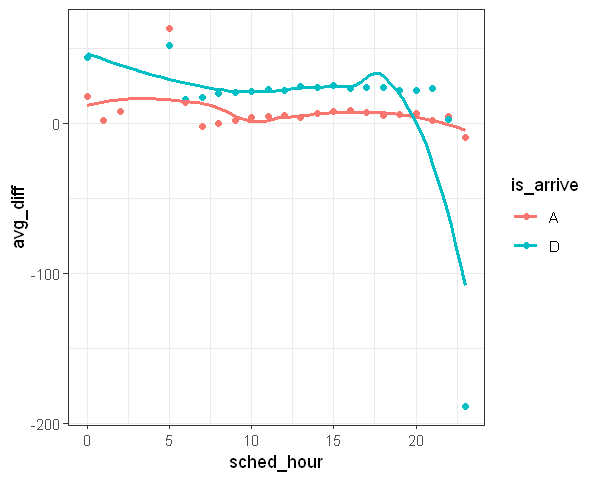

In [28]:
df_afsnt2 %>% 
  group_by(sched_hour, is_arrive) %>% 
  summarise(avg_diff = mean(diff, na.rm = TRUE)) %>%   
  ggplot(aes(sched_hour, avg_diff, color = is_arrive)) +
    geom_point() +
  geom_smooth(se = FALSE)

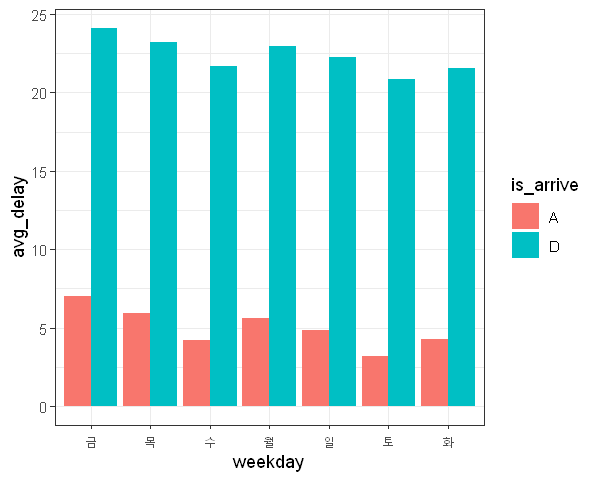

In [29]:
df_afsnt2 %>%
  group_by(weekday, is_arrive) %>%
  summarize(avg_delay = mean(diff, na.rm = TRUE)) %>%
  ggplot() +
  geom_col(mapping = aes(x = weekday, y = avg_delay, fill = is_arrive),
           position = 'dodge')

월화수목금토일 순서 바꾸자.

### Multivariate

# Features

## Create or Transform Features

## Feature Engineering

## Missing Value Imputation

# Modeling 

In [ ]:
# data = data.split(by = '연결지연변수')

# 연결지연 변수를 임의로 설정하였다.
# 지연여부와 겹치는 변수인 지연사유, 결항사유, 실제시각은 제거하였음
# 파이프라인을 추가하면 더 빠를 것임.


df_afsnt2 = df_afsnt.drop(['ATT', 'DRR', 'CNR'], axis = 1)
df_afsnt_split = tuple(df_afsnt2.groupby(['SDT_YY', 'SDT_MM', 'SDT_DD', 'REG'])) 
_, df_afsnt_split = zip(*df_afsnt_split) # group을 _(불필요)로, 데이터를 df_afsnt_split으로 튜플 언패킹
idx_ = list(range(len(df_afsnt_split)))

kfold = ms.KFold(5, shuffle = True, random_state = 42)

# 여기에 인코딩 코드 추가

def CV_by_chain(model_name):  
    model_data = []
    auc = []
    
    for idx_train, idx_val in kfold.split(idx_):
        pre_df_train = [df_afsnt_split[idx] for idx in idx_train]
        pre_df_val = [df_afsnt_split[idx] for idx in idx_val]
        
        df_train = pd.concat(pre_df_train)
        df_val = pd.concat(pre_df_val)
        
        X_train = df_train.drop('DLY', 1)
        y_train = df_train['DLY']
        X_val = df_val.drop('DLY', 1)
        y_val = df_val['DLY']


        if model_name == "logistic":
            logr = lm.LogisticRegression(solver = 'liblinear')
            reg = logr.fit(X_train, y_train)
            y_pred = reg.predict_proba(X_val)[:, 1]
            

            # 차후에 추가될 모델들
    #         elif model_name == "???":
    #             clf = ???.fit(X_train, y_train)
    #             y_pred = clf.predict(X_test)


        auc.append(mt.roc_auc_score(y_val, y_pred))
        
    
    return auc


print(CV_by_chain("logistic"))

## Make the Modeling data

## Linear Models

## Tree-based Models

## Others

## Stacking

# Conclusion